In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from itertools import chain
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

In [2]:
# Preprocessing data and helpers
number = re.compile('[\d,]+')
def get_first_number(val):
    matched = number.match(str(val))
    if matched:
        return int(matched.group().replace(',', ''))
    else:
        return np.nan

def dict_map(dict_to_use):
    def mapper(val):
        if val in dict_to_use:
            return dict_to_use[val]
        else:
            return np.nan

    return mapper

def split_list(list_str):
    return np.core.defchararray.split(list_str, sep='; ')

def userlist_to_cols(col):
    list_elems = col.astype(np.str).apply(split_list)
    categories = set(chain.from_iterable(list_elems.values))
    categories.discard('nan')
    categories = pd.Series(list(categories))
    
    def category_to_cols(category):
        return list_elems.map(lambda user_resp: category in user_resp)\
                         .rename('%s_%s' % (col.name, category))\
                         .astype('int8')
    
    new_cols = categories.map(category_to_cols)
    return pd.concat(new_cols.values, axis=1)

listvals = [
    'self_identification',
    'tech_do',
    'tech_want',
    'dev_environment',
    'education',
    'new_job_value',
    'how_to_improve_interview_process',
    'developer_challenges',
    'why_stack_overflow',
]

number_parses = [
    'company_size_range',
    'team_size_range',
    'women_on_team',
    'hobby',
    'rep_range',
    'interview_likelihood',
]

to_drop = [
    'age_range',
    'experience_range',
    'salary_range',
]

satisfaction_strs = {
    'I love my job': 10,
    'I\'m somewhat satisfied with my job': 7.5,
    'I\'m neither satisfied nor dissatisfied with my job': 5,
    'I\'m somewhat dissatisfied with my job': 2.5,
    'I hate my job': 0,
}

agree_strs = {
    'Agree completely': 5,
    'Agree somewhat': 4,
    'Neutral': 3,
    'Disagree somewhat': 2,
    'Disagree completely': 1,
}

important_strs = {
    'This is very important': 3,
    'This is somewhat important': 2,
    'I don\'t care about this': 1,
}

In [3]:
# 2016 preproc
data = pd.read_csv('data/2016.csv')
data['job_satisfaction'] = data['job_satisfaction']\
                                    .map(satisfaction_strs).astype('float')
data = data[data['job_satisfaction'].notnull()]

data['gender_M'] = (data['gender'] == 'Male').astype('int8')
data['gender_F'] = (data['gender'] == 'Female').astype('int8')
to_drop.append('gender')

to_drop.extend(listvals)
for index in listvals:
    data = pd.concat([data, userlist_to_cols(data[index])], axis=1)

data[number_parses] = data[number_parses].applymap(get_first_number).astype('float')

agree_keys = [index for index in data if 'agree_' in index]
data[agree_keys] = data[agree_keys].applymap(dict_map(agree_strs))

important_keys = [index for index in data if 'important_' in index]
data[important_keys] = data[important_keys].applymap(dict_map(important_strs))

data.drop(to_drop, axis=1, inplace=True)
data = pd.get_dummies(data)

print ('Columns with NaNs:')
for key in data:
    if data[key].isnull().any():
        print (key)
data.fillna(data.mean(), inplace=True)
print ('Filling with mean of column')

Columns with NaNs:
age_midpoint
experience_midpoint
salary_midpoint
big_mac_index
programming_ability
company_size_range
team_size_range
women_on_team
hobby
rep_range
interview_likelihood
agree_tech
agree_notice
agree_problemsolving
agree_diversity
agree_adblocker
agree_alcohol
agree_loveboss
agree_nightcode
agree_legacy
agree_mars
important_variety
important_control
important_sameend
important_newtech
important_buildnew
important_buildexisting
important_promotion
important_companymission
important_wfh
important_ownoffice
Filling with mean of column


In [4]:
data = data.drop(['Unnamed: 0'], axis=1)

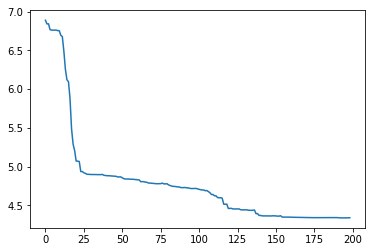

In [5]:
pca = PCA()
x_pca = pca.fit_transform(data.drop("job_satisfaction",1))

x_train, x_test, y_train, y_test = train_test_split(x_pca, data.job_satisfaction, test_size=0.30, random_state=43)

mse_rid = []
model = RidgeCV(alphas=[0.0001, 0.00021, 0.3333, 0.5, .00001, 0.59, 1, 5, 100, 1000, 10000, 99999, 100000])
for i in range(1,200):
    fit = model.fit(x_train[:,:i], y_train)
    x_sub = x_test[:,:i]
    lin_incpt_pred = fit.predict(x_sub)
    mse_rid.append(mean_squared_error(y_test, lin_incpt_pred))
plt.plot(mse_rid)

In [6]:
num_feats = 160
x_train, x_test, y_train, y_test = train_test_split(x_pca, data.job_satisfaction, test_size=0.30, random_state=43)
fit = model.fit(x_train[:,:num_feats], y_train)
pred = fit.predict(x_test[:,:num_feats])
print(mean_squared_error(y_test, pred))

4.34745713248


## XGB

## StackNet<br>
From https://github.com/kaz-Anova/StackNet 

In [26]:
x_train_pca = pd.DataFrame(x_train[:,:num_feats])
y_train_pca = pd.DataFrame(y_train).reset_index().drop("index",1)
x_test_pca = pd.DataFrame(x_test[:,:num_feats])
y_test_pca = pd.DataFrame(y_test).reset_index().drop("index",1)
train_new = pd.concat([y_train_pca, x_train_pca], 1)
test_new = pd.concat([y_test_pca, x_test_pca], 1)
# train_new.to_csv("data/trainSN_2016.csv", index = False)
# test_new.to_csv("data/testSN_2016.csv", index = False)

,job_satisfaction,0,1,2,3,4,5,6,7,8,...,150,151,152,153,154,155,156,157,158,159
0,10.0,-4921.001128,-1378.606228,-1004.733504,-56.013559,3.676947,-4.175717,-2.524487,0.177351,2.505159,...,0.476768,0.195377,0.343129,-0.011423,-0.185483,0.178059,0.612113,-0.052068,0.005976,0.447473
1,2.5,-28.164809,-1521.426284,-1045.291854,34.395553,-6.869342,0.618277,0.795725,3.900723,-1.938109,...,-0.053999,-0.226312,0.016318,0.257727,0.103405,-0.091798,-0.007131,0.001253,-0.501016,-0.195517
2,2.5,-54917.033561,-816.900118,-690.920505,6.523289,-5.682371,-3.000921,0.002277,1.933883,2.352499,...,-0.098852,0.163760,-0.248953,-0.225594,0.076318,-0.396292,-0.572256,-0.347007,-0.245213,-0.097342
3,7.5,25075.493026,-1763.586335,-1252.546563,28.037177,-4.309423,9.888983,-2.521300,5.460652,0.355669,...,-0.097929,0.183832,0.163045,-0.175502,0.055596,0.199574,-0.246516,0.018979,-0.016922,-0.079443
4,10.0,25081.648690,-1863.536456,-352.646646,-0.910340,12.209332,-3.711286,-1.740102,-0.736498,2.489110,...,0.296143,0.737779,-0.032134,0.122150,0.584368,-0.691982,-0.076097,-0.243307,0.227358,-0.116877
5,2.5,-24837.049552,-1132.521052,9060.059482,7.284942,0.782744,-3.736404,-0.493218,-3.707449,-1.161712,...,0.281873,-0.240387,-0.256340,-0.065988,0.091304,-0.122331,0.054555,-0.106912,0.114674,0.099484
6,10.0,-34918.333427,-993.543282,-856.009421,-0.766433,-5.154680,9.949983,0.481009,-4.205014,0.659317,...,-0.260626,0.486247,-0.064253,0.042815,0.197572,0.353779,-0.185007,-0.065237,0.628154,0.182138
7,10.0,15078.940929,-1715.663954,-769.997926,-53.111351,1.542531,9.306208,-2.980836,0.107943,-0.684938,...,0.559346,-0.136077,0.224646,0.395729,-0.418218,0.007178,0.014756,-0.019875,0.189319,-0.161186
8,7.5,-24907.947507,-221.955863,-937.758564,41.168788,-4.019447,-3.794043,-2.065783,1.265707,-1.329738,...,0.089127,0.151302,0.301005,-0.250278,-0.101767,-0.145014,-0.636855,-0.219011,0.083013,0.118811
9,2.5,85148.984860,-2634.052784,8151.515513,16.770789,-15.871215,-0.902065,-3.457200,0.227376,0.363628,...,-0.090928,0.591375,0.131490,-0.268944,0.105609,-0.656605,-1.071617,-0.227386,-0.167457,0.399083


First Layer:<br>
LogisticRegression Type:Liblinear C:2.0 threads:1 usescale:True maxim_Iteration:100 seed:1 verbose:false
GradientBoostingForestRegressor rounding:6 estimators:1000 shrinkage:0.1 offset:0.00001 max_tree_size:-1 cut_off_subsample:1.0 max_depth:8 max_features:0.4 min_leaf:4.0 min_split:8.0 Objective:RMSE row_subsample:0.7 seed:1 threads:1 bags:1 verbose:false<br>
RandomForestRegressor bootsrap:false max_tree_size:-1 cut_off_subsample:1.0 feature_subselection:1.0 rounding:6 estimators:100 offset:0.00001 max_depth:6 max_features:0.4 min_leaf:2.0 min_split:5.0 Objective:RMSE row_subsample:0.95 seed:1 threads:1 bags:1 verbose:false<br>
multinnregressor usescale:True maxim_Iteration:50 Objective:RMSE tau:0.5 UseConstant:true C:0.000001 shuffle:true tolerance:0.01 learn_rate:0.01 smooth:0.1 h1:20 h2:20 connection_nonlinearity:Relu init_values:0.02 seed:1 threads:1 bags:1 verbose:false<br>
LibFmRegressor maxim_Iteration:30 C:0.00001 C2:0.01 lfeatures:2 seed:1 usescale:True init_values:0.1 learn_rate:0.03 smooth:10.1 verbose:false<br>
GradientBoostingForestRegressor rounding:3 estimators:300 shrinkage:0.16 threads:1 cut_off_subsample:0.9 offset:0.1 max_depth:6 max_features:0.5 min_leaf:1.0 min_split:2.0 Objective:RMSE row_subsample:0.8 seed:1 verbose:false<br>
LinearRegression Type:Routine C:0.01 RegularizationType:L1 threads:1 usescale:True seed:1 verbose:false<br>
<br>
Second Layer:<br>
RandomForestRegressor rounding:12 estimators:1500 threads:5 max_depth:6 max_features:0.2 min_leaf:1.0 min_split:2.0 Objective:RMSE seed:1 verbose:false<br>
<br>
Resulted in RMSE: 3.167

In [ ]:
# data contains a DataFrame with no NaNs, all numbers.
# We're trying to predict the "job_satisfaction" column.